In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests as fdrcorrection

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
#Load Residuals and Functional Site Data

base_dir = "/content"

#Residual data:
residuals_file = f"{base_dir}/mutation_level_residuals_debug (2).csv"
df_res = pd.read_csv(residuals_file, on_bad_lines='skip')

#Domainome functional residue annotations
funsites_file = f"/content/gdrive/MyDrive/Datasets/domainome_functional_residues.txt"
df_funsites = pd.read_csv(funsites_file, sep="\t", header=None, names=["uniprot_ID", "cdd_ID", "cdd_description", "pos_in_uniprot", "WT_aa"])

print("df_res shape:", df_res.shape)
print("df_funsites shape:", df_funsites.shape)

print("\ndf_res columns")
print(df_res.columns.tolist())

print("\ndf_funsites columns")
print(df_funsites.columns.tolist())

<ipython-input-5-ee0e5bad18d1>:7: DtypeWarning: Columns (107) have mixed types. Specify dtype option on import or set low_memory=False.
  df_res = pd.read_csv(residuals_file, on_bad_lines='skip')


df_res shape: (390853, 123)
df_funsites shape: (31686, 5)

df_res columns
['wt_seq', 'aa_seq', 'dom_ID', 'variant_ID', 'pos', 'pos_in_uniprot', 'WT', 'wt_aa', 'mut_aa', 'nt_seq', 'Nham_nt', 'Nham_aa', 'Nmut_codons', 'indel', 'STOP', 'STOP_readthrough', 'count_e1_s0', 'count_e2_s0', 'count_e3_s0', 'count_e1_s1', 'count_e2_s1', 'count_e3_s1', 'mean_count', 'fitness1_uncorr', 'fitness2_uncorr', 'fitness3_uncorr', 'sigma1_uncorr', 'sigma2_uncorr', 'sigma3_uncorr', 'fitness', 'sigma', 'growthrate1', 'growthrate1_sigma', 'growthrate2', 'growthrate2_sigma', 'growthrate3', 'growthrate3_sigma', 'growthrate', 'growthrate_sigma', 'library', 'missing', 'dead', 'secondary_structure_code', 'secondary_structure', 'Phi', 'Psi', 'Area', 'sasa_all', 'rsasa_all', 'sasa_sidechain', 'rsasa_sidechain', 'sasa_mainchain', 'rsasa_mainchain', 'sasa_nonpolar', 'rsasa_nonpolar', 'sasa_polar', 'rsasa_polar', 'pLDDT', 'vdw_inter', 'vdw_intra', 'sb_inter', 'sb_intra', 'hbbb_inter', 'hbbb_intra', 'hbsb_inter', 'hbsb_

In [6]:
# Basic Merging & Setup


if "uniprot_ID" not in df_res.columns:
 df_res["uniprot_ID"] = df_res["dom_ID"].str.split("_", n=1, expand=True)[0]


df_res = df_res[~df_res["pos_in_uniprot"].isna()]
df_funsites = df_funsites[~df_funsites["pos_in_uniprot"].isna()]

#typecast important
df_res["pos_in_uniprot"] = df_res["pos_in_uniprot"].astype(int)
df_funsites["pos_in_uniprot"] = df_funsites["pos_in_uniprot"].astype(int)

#Create a residue_key or position key
df_res["uniprot_ID_pos_in_uniprot"] = df_res["uniprot_ID"].astype(str) + "_" + df_res["pos_in_uniprot"].astype(str)

df_funsites["uniprot_ID_pos_in_uniprot"] = (df_funsites["uniprot_ID"].astype(str) + "_" + df_funsites["pos_in_uniprot"].astype(str))

#Merge cdd_ID_description
df_funsites["cdd_ID_description"] = df_funsites["cdd_ID"].astype(str) + "_" + df_funsites["cdd_description"].astype(str)

#a simple 'funsite' label on df_res
df_res["funsite"] = np.where(df_res["uniprot_ID_pos_in_uniprot"].isin(df_funsites["uniprot_ID_pos_in_uniprot"]),
  "yes", "no")

print("Number of funsites = yes:", (df_res["funsite"]=="yes").sum())

<ipython-input-6-3e51ba588b54>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["pos_in_uniprot"] = df_res["pos_in_uniprot"].astype(int)


Number of funsites = yes: 46033


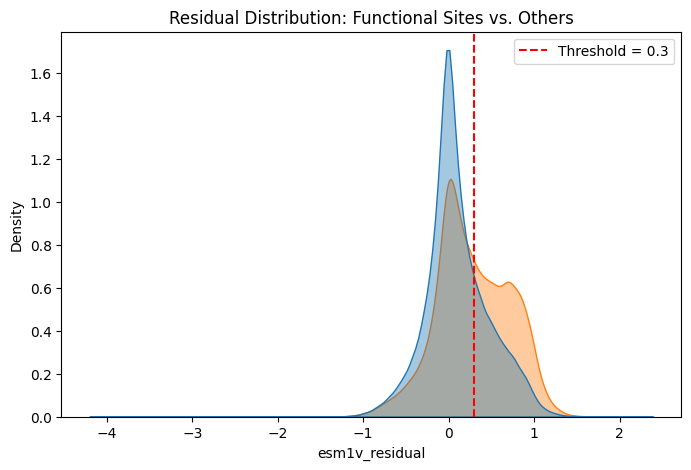

In [8]:
#Distribution of Residuals
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_res, x="esm1v_residual", hue="funsite", common_norm=False, fill=True, alpha=0.4)
plt.axvline(0.3, color="red", linestyle="--", label="Threshold = 0.3")
plt.title("Residual Distribution: Functional Sites vs. Others")
plt.legend()
plt.savefig("Residual_distribution_FunvsOthers.pdf", bbox_inches='tight')
plt.show()

In [9]:

# Cell 5: Merge Additional Columns from funsites

# Drop rows where these fields are missing (keys)
df_res = df_res.dropna(subset=["uniprot_ID", "pos_in_uniprot"])
df_funsites = df_funsites.dropna(subset=["uniprot_ID", "pos_in_uniprot"])

# Convert pos_in_uniprot to int if it's float
df_res["pos_in_uniprot"] = df_res["pos_in_uniprot"].astype(int)
df_funsites["pos_in_uniprot"] = df_funsites["pos_in_uniprot"].astype(int)

# Rebuild the merge key
df_res["uniprot_ID_pos_in_uniprot"] = (
  df_res["uniprot_ID"].astype(str) + "_" + df_res["pos_in_uniprot"].astype(str))

df_funsites["uniprot_ID_pos_in_uniprot"] = (
  df_funsites["uniprot_ID"].astype(str) + "_" + df_funsites["pos_in_uniprot"].astype(str))

# Merge
df_merged = pd.merge(df_res, df_funsites[["uniprot_ID_pos_in_uniprot","cdd_ID","cdd_description","cdd_ID_description"]],
                     on="uniprot_ID_pos_in_uniprot",how="left", suffixes=("","_site"))

print("df_merged shape:", df_merged.shape)
print("Head of df_merged:\n", df_merged.head(5))

# Rename certain site names
df_merged["cdd_description"] = np.where(df_merged["cdd_description"] == "zinc binding site", "Zn binding site",
  df_merged["cdd_description"])

#Fill missing cdd_description with "none" for grouping
df_merged["cdd_description"] = df_merged["cdd_description"].fillna("none")

print("\nFinal cdd_description distribution:\n", df_merged["cdd_description"].value_counts().head())

df_merged shape: (418671, 129)
Head of df_merged:
                                               wt_seq  \
0  EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...   
1  EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...   
2  EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...   
3  EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...   
4  EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...   

                                              aa_seq              dom_ID  \
0  EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWPFVSTAEEQGW...  A1X283_PF00018_155   
1  EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...  A1X283_PF00018_155   
2  EQYVVVANYQKQESSEISLSVGQVVDIIPKNESGWWFVSTAEEQGW...  A1X283_PF00018_155   
3  EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQPW...  A1X283_PF00018_155   
4  EQYVVVANYQKQESSEDSLSVGQVVDIIEKNESGWWFVSTAEEQGW...  A1X283_PF00018_155   

                variant_ID   pos  pos_in_uniprot     WT wt_aa mut_aa  nt_seq  \
0  A1X283_PF00018_155_W36P  36.0             190  False     W      P     Na

In [10]:
df_merged["cdd_description"].unique()

array(['none', 'peptide ligand binding site', 'binding pocket',
       'DNA binding site', 'specific DNA base contacts',
       'protein binding site', 'putative DNA binding site',
       'RNA-binding motif', 'DNA-binding site', 'Zn binding site',
       'polypeptide substrate binding site',
       'putative DAG/PE binding site', 'RNA binding site',
       'PTKc domain interface', 'Ca2+ binding site',
       'non-specific DNA binding site',
       'sequence-specific DNA binding site', 'salt bridge',
       'putative RBD_Raf-KRas interaction site',
       'RBD_Raf-Ras interaction site', 'Ca binding site',
       'dimer interface', 'SAP interaction site',
       'putative RBD_Raf-Ras interaction site',
       'RBD_Raf-KRas interaction site', 'putative Ca binding site',
       'heterodimer interface', 'swapped dimer interface',
       'ERK2 MAP kinase docking site', 'homodimer interface',
       'RXR/ECR heterodimer interface', 'RXR/RXR homodimer interface DR2',
       'RXR/PPAR heterodim

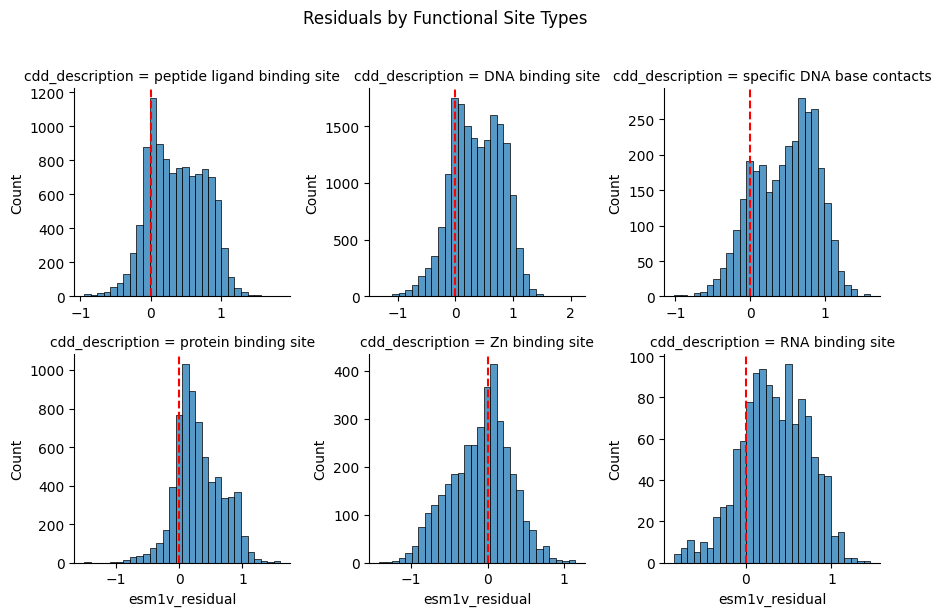

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Representative site types you want to highlight
selected_site_types = ["specific DNA base contacts", "peptide ligand binding site", "DNA binding site", "RNA binding site", "Zn binding site",
"protein binding site"]

# Filter the dataframe
df_facet = df_merged[df_merged["cdd_description"].isin(selected_site_types)].copy()

# Plot as facets
g = sns.FacetGrid(df_facet, col="cdd_description", col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="esm1v_residual", bins=30, kde=False)

# Add vertical line at residual = 0
for ax in g.axes.flat:
  ax.axvline(0, color="red", linestyle="--")

g.fig.suptitle("Residuals by Functional Site Types", y=1.02)
g.fig.tight_layout()
plt.savefig("ResidualsbyFunSiteTypes.pdf", bbox_inches='tight')
plt.show()

In [12]:
#Residue-Level Aggregation and Fisher Test

#Prepare variance column
df_merged["var"] = df_merged["scaled_gr_sigma"] ** 2
df_merged = df_merged[~df_merged["var"].isna() & (df_merged["var"] > 0)]

#Compute merged residual per site using inverse-variance weighting
agg_by_site = df_merged.groupby("uniprot_ID_pos_in_uniprot").apply(
  lambda g: pd.Series({"merged_esm1v_residual": np.sum(g["esm1v_residual"] / g["var"]) / np.sum(1 / g["var"]),
    "merged_sigma": 1 / np.sum(1 / g["var"]), "cdd_description": g["cdd_description"].iloc[0],
    "funsite": g["funsite"].iloc[0], "cdd_ID_description": g["cdd_ID_description"].iloc[0],
    "PFAM_ID": g["PFAM_ID"].iloc[0] if "PFAM_ID" in g else None,
    "dom_ID": g["dom_ID"].iloc[0]})).reset_index()

#Threshold-based flag
agg_by_site["sig"] = np.where(agg_by_site["merged_esm1v_residual"] > 0.3, "yes", "no")

#Rename just to match downstream easier
agg_by_site.rename(columns={"uniprot_ID_pos_in_uniprot": "residue_key"}, inplace=True)

#Save to CSV
agg_by_site.to_csv("/content/esm1v_agg_by_site.csv", index=False)
print("Saved site-level residuals to /content/esm1v_agg_by_site.csv")

#Summary table
cont_table = pd.crosstab(agg_by_site["sig"], agg_by_site["funsite"])
print("\nContingency table:\n", cont_table)
oddsratio, pval = fisher_exact(cont_table)
print(f"Fisher test (site level): OR={oddsratio:.3f}, p={pval:.1e}")

<ipython-input-12-23fbad67f382>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_by_site = df_merged.groupby("uniprot_ID_pos_in_uniprot").apply(


Saved site-level residuals to /content/esm1v_agg_by_site.csv

Contingency table:
 funsite     no   yes
sig                 
no       15219  1303
yes       4157  1300
Fisher test (site level): OR=3.653, p=3.3e-193


This cell is doing some very important statistical analysis at the residue level, and it’s giving a quantitative answer to the question:

Are functional sites more likely to have high residuals, where ESM predictions diverge from experimental measurements?


the above results show that, “Mutations at functional sites tend to have higher residuals, ESM1v predictions systematically under or overestimate their functional impact.”



In [13]:
#Per-Site-Type Enrichment
#Which types of functional sites are significantly enriched for high residuals

# Threshold to define significance
agg_by_site["sig"] = np.where(agg_by_site["merged_esm1v_residual"] > 0.3, "yes", "no")

# Ensure cdd_description has "none" for NA
agg_by_site["cdd_description"] = agg_by_site["cdd_description"].fillna("none")

# Restrict to site types with at least 50 annotated positions
site_counts = agg_by_site["cdd_description"].value_counts()
site_types_50 = site_counts[site_counts >= 50].index.tolist()
agg_filtered = agg_by_site[agg_by_site["cdd_description"].isin(site_types_50)].copy()

# Pre-compute baseline "none" group stats for pairwise testing
none_group = agg_filtered[agg_filtered["cdd_description"] == "none"]
none_sig = (none_group["sig"] == "yes").sum()
none_nonsig = (none_group["sig"] == "no").sum()

# Perform Fisher test per cdd_description
results = []
for desc, df_sub in agg_filtered.groupby("cdd_description"):
  yes = (df_sub["sig"] == "yes").sum()
  no = (df_sub["sig"] == "no").sum()
  table = [[yes, no], [none_sig, none_nonsig]]

  try:
    odds, p = fisher_exact(table)
    results.append({"cdd_description": desc, "oddsratio": odds, "pval": p, "yes": yes,"no": no})
  except:
    continue

df_fisher_by_site = pd.DataFrame(results)
df_fisher_by_site["fdr"] = fdrcorrection(df_fisher_by_site["pval"])[1]

# Filter significant ones
df_fisher_sig = df_fisher_by_site[df_fisher_by_site["fdr"] < 0.1].copy()
df_fisher_sig = df_fisher_sig.sort_values("oddsratio", ascending=False)

print("\nSignificant site types (FDR < 0.1):")
print(df_fisher_sig[["cdd_description", "oddsratio", "pval", "fdr"]])


Significant site types (FDR < 0.1):
                       cdd_description  oddsratio           pval  \
11          specific DNA base contacts   9.485457   1.090815e-21   
5          peptide ligand binding site   7.516844   6.960903e-61   
0                     DNA binding site   6.468686  1.407650e-142   
1                     RNA binding site   6.004128   1.307644e-12   
10  putative nucleic acid binding site   5.125475   2.832458e-13   
8            putative DNA binding site   3.942673   9.273331e-07   
7                 protein binding site   2.523639   1.407451e-08   
3                      Zn binding site   0.168601   2.284768e-09   

              fdr  
11   1.199897e-20  
5    8.353083e-60  
0   1.829945e-141  
1    1.176880e-11  
10   2.832458e-12  
8    5.563986e-06  
7    9.852157e-08  
3    1.827815e-08  


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [14]:
# Load previously computed enrichment table
df_fisher_sig = df_fisher_by_site[df_fisher_by_site["fdr"] < 0.1]
top_sites_to_plot = df_fisher_sig.sort_values("oddsratio", ascending=False).head(6)["cdd_description"].tolist()
print("Top sites to plot:", top_sites_to_plot)

Top sites to plot: ['specific DNA base contacts', 'peptide ligand binding site', 'DNA binding site', 'RNA binding site', 'putative nucleic acid binding site', 'putative DNA binding site']


<ipython-input-15-10e41cd416c7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fisher_sig[["ci_low", "ci_high"]] = df_fisher_sig.apply(fisher_ci, axis=1)
<ipython-input-15-10e41cd416c7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fisher_sig[["ci_low", "ci_high"]] = df_fisher_sig.apply(fisher_ci, axis=1)


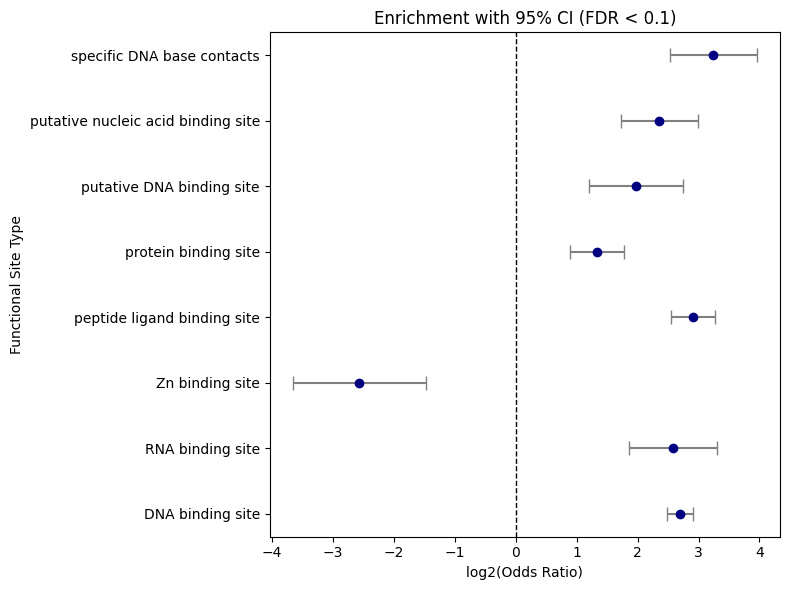

In [15]:
from scipy.stats import fisher_exact

# Compute confidence intervals
def fisher_ci(row):
    table = [[int(row['yes']), int(row['no'])], [none_sig, none_nonsig]]
    try:
        res = fisher_exact(table)
        odds = res[0]
        log_or = np.log(odds)
        se = np.sqrt(1 / table[0][0] + 1 / table[0][1] + 1 / table[1][0] + 1 / table[1][1])
        ci_low = np.exp(log_or - 1.96 * se)
        ci_high = np.exp(log_or + 1.96 * se)
        return pd.Series([ci_low, ci_high])
    except:
        return pd.Series([np.nan, np.nan])

df_fisher_sig[["ci_low", "ci_high"]] = df_fisher_sig.apply(fisher_ci, axis=1)

#Plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=np.log2(df_fisher_sig["oddsratio"]),y=df_fisher_sig["cdd_description"],
    xerr=[np.log2(df_fisher_sig["oddsratio"]) - np.log2(df_fisher_sig["ci_low"]),
        np.log2(df_fisher_sig["ci_high"]) - np.log2(df_fisher_sig["oddsratio"])],
    fmt='o', color="navy", ecolor='gray', capsize=5)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("log2(Odds Ratio)")
plt.ylabel("Functional Site Type")
plt.title("Enrichment with 95% CI (FDR < 0.1)")
plt.tight_layout()
plt.savefig("FunSitesEnrichment.pdf", bbox_inches='tight')
plt.show()

In [16]:
df_merged.head()

,wt_seq,aa_seq,dom_ID,variant_ID,pos,pos_in_uniprot,WT,wt_aa,mut_aa,nt_seq,...,pval_sigma,fdr_sigma,significant_sigma,uniprot_ID,uniprot_ID_pos_in_uniprot,funsite,cdd_ID,cdd_description,cdd_ID_description,var
0,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWPFVSTAEEQGW...,A1X283_PF00018_155,A1X283_PF00018_155_W36P,36.0,190,False,W,P,NaN,...,0.390867,0.519626,False,A1X283,A1X283_190,no,NaN,none,NaN,0.033737
1,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,A1X283_PF00018_155,A1X283_PF00018_155_L52D,52.0,206,False,L,D,NaN,...,0.736265,0.821598,False,A1X283,A1X283_206,no,NaN,none,NaN,0.028989
2,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEISLSVGQVVDIIPKNESGWWFVSTAEEQGW...,A1X283_PF00018_155,A1X283_PF00018_155_E29P,29.0,183,False,E,P,NaN,...,0.923471,0.951861,False,A1X283,A1X283_183,no,NaN,none,NaN,0.068094
3,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQPW...,A1X283_PF00018_155,A1X283_PF00018_155_G45P,45.0,199,False,G,P,NaN,...,0.464424,0.591656,False,A1X283,A1X283_199,no,NaN,none,NaN,0.068016
4,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEDSLSVGQVVDIIEKNESGWWFVSTAEEQGW...,A1X283_PF00018_155,A1X283_PF00018_155_I17D,17.0,171,False,I,D,NaN,...,0.763918,0.842143,False,A1X283,A1X283_171,no,NaN,none,NaN,0.135290


In [17]:
top_fun = df_merged[(df_merged["esm1v_residual"] > 0.5) &(df_merged["funsite"] == "yes")]
unique_sites = top_fun[["uniprot_ID","pos_in_uniprot", "esm1v_residual", "cdd_description", "aa_seq", "wt_seq", "dom_ID", "variant_ID"]].drop_duplicates()
print(unique_sites)

       uniprot_ID  pos_in_uniprot  esm1v_residual  \
20         A1X283             188        0.749433   
27         A1X283             200        0.559647   
37         A1X283             188        0.603458   
41         A1X283             163        0.747233   
45         A1X283             200        0.696049   
...           ...             ...             ...   
417931     Q9Y6N9             221        0.890381   
417947     Q9Y6N9             221        0.881194   
417961     Q9Y6N9             221        0.915178   
417973     Q9Y6N9             221        0.682877   
418064     Q9Y6N9             221        0.816586   

                    cdd_description  \
20      peptide ligand binding site   
27      peptide ligand binding site   
37      peptide ligand binding site   
41      peptide ligand binding site   
45      peptide ligand binding site   
...                             ...   
417931         protein binding site   
417947         protein binding site   
417961      

In [18]:
unique_sites.to_csv("/content/unique_sites.csv", index=False)

In [32]:
top_fun_sites = df_merged[(df_merged["esm1v_residual"] > 0.5) & (df_merged["funsite"] == "yes")]

#look at top candidates
top_fun_sites[["uniprot_ID", "pos_in_uniprot", "esm1v_residual", "cdd_description", "dom_ID"]].head(1000)

,uniprot_ID,pos_in_uniprot,esm1v_residual,cdd_description,dom_ID
20,A1X283,188,0.749433,peptide ligand binding site,A1X283_PF00018_155
21,A1X283,188,0.749433,peptide ligand binding site,A1X283_PF00018_155
22,A1X283,188,0.749433,peptide ligand binding site,A1X283_PF00018_155
27,A1X283,200,0.559647,peptide ligand binding site,A1X283_PF00018_155
28,A1X283,200,0.559647,peptide ligand binding site,A1X283_PF00018_155
...,...,...,...,...,...
17530,O15405,259,0.828792,DNA binding site,O15405_PF00505_256
17531,O15405,274,0.705280,DNA binding site,O15405_PF00505_256
17535,O15405,287,0.542048,DNA binding site,O15405_PF00505_256
17538,O15405,267,0.690530,DNA binding site,O15405_PF00505_256


In [21]:
df_merged.columns.to_list()

['wt_seq',
 'aa_seq',
 'dom_ID',
 'variant_ID',
 'pos',
 'pos_in_uniprot',
 'WT',
 'wt_aa',
 'mut_aa',
 'nt_seq',
 'Nham_nt',
 'Nham_aa',
 'Nmut_codons',
 'indel',
 'STOP',
 'STOP_readthrough',
 'count_e1_s0',
 'count_e2_s0',
 'count_e3_s0',
 'count_e1_s1',
 'count_e2_s1',
 'count_e3_s1',
 'mean_count',
 'fitness1_uncorr',
 'fitness2_uncorr',
 'fitness3_uncorr',
 'sigma1_uncorr',
 'sigma2_uncorr',
 'sigma3_uncorr',
 'fitness',
 'sigma',
 'growthrate1',
 'growthrate1_sigma',
 'growthrate2',
 'growthrate2_sigma',
 'growthrate3',
 'growthrate3_sigma',
 'growthrate',
 'growthrate_sigma',
 'library',
 'missing',
 'dead',
 'secondary_structure_code',
 'secondary_structure',
 'Phi',
 'Psi',
 'Area',
 'sasa_all',
 'rsasa_all',
 'sasa_sidechain',
 'rsasa_sidechain',
 'sasa_mainchain',
 'rsasa_mainchain',
 'sasa_nonpolar',
 'rsasa_nonpolar',
 'sasa_polar',
 'rsasa_polar',
 'pLDDT',
 'vdw_inter',
 'vdw_intra',
 'sb_inter',
 'sb_intra',
 'hbbb_inter',
 'hbbb_intra',
 'hbsb_inter',
 'hbsb_intra',
 

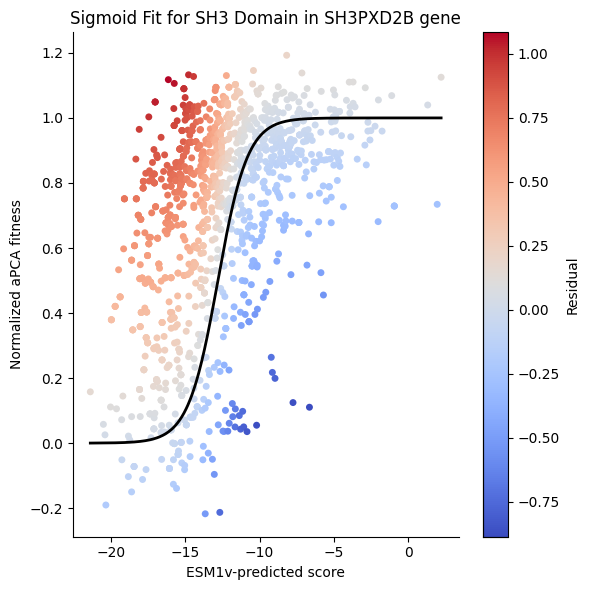

In [38]:
dom_id = "A1X283_PF00018_155"
df_plot = df_merged[df_merged['dom_ID'] == dom_id].copy()

#Sort for sigmoid line
df_plot = df_plot.sort_values('esm1vfl_score')

# Plot
plt.figure(figsize=(6, 6))

#colored by residual
sc = plt.scatter(df_plot['esm1vfl_score'],df_plot['scaled_gr_tofit'],c=df_plot['esm1v_residual'],
    cmap='coolwarm',s=25,edgecolors='none')

#Overlay sigmoid fit
plt.plot(df_plot['esm1vfl_score'],df_plot['sigmoid_pred'],color='black',linewidth=2)


plt.xlabel("ESM1v-predicted score")
plt.ylabel("Normalized aPCA fitness")
plt.title(f"Sigmoid Fit for SH3 Domain in SH3PXD2B gene")
cbar = plt.colorbar(sc)
cbar.set_label("Residual")
sns.despine()
plt.tight_layout()


plt.savefig(f"{dom_id}_sigmoid_fit.pdf", dpi=300, bbox_inches='tight')

plt.show()